In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [96]:
# 获取events

# Triple-Barrier Labeling Method [3.2]
def applyPtSlOnT1(close, events, ptSl, molecule=None):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    if molecule is not None:
        events_ = events.loc[molecule]
    else:
        events_ = events
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0: 
        pt = ptSl[0] * events_['trgt']
    else: 
        pt = pd.Series(index=events.index) # NaNs
        
    if ptSl[1] > 0: 
        sl = -ptSl[1] * events_['trgt']
    else: 
        sl = pd.Series(index=events.index) # NaNs
        
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0 < sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0 > pt[loc]].index.min() # earliest profit taking
    return out

# =======================================================
# Gettting Time of First Touch (getEvents) [3.3]
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=1, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt > minRet] # minRet
    print("len of target: {}".format(len(trgt)))
    
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
        
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: 
        side_, ptSl_ = side.loc[trgt.index],ptSl[:2]
        
    events=(
        pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1).dropna(subset=['trgt'])
    )
    print("len of events: {}".format(len(events)))
    
    df0 = applyPtSlOnT1(close, events, ptSl_)
    #     df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
    #                     numThreads=numThreads,close=close,events=events,
    #                     ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) #pd.min ignores nan
    if side is None: events=events.drop('side',axis=1)
    return events

# Adding Vertical Barrier [3.4]
def addVerticalBarrier(tEvents, close, numDays=1):
    t1 = close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1 = t1[t1<close.shape[0]]
    t1 = (pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

# meta-labeling
def getBins(events, close):
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    # 2) Create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    
    if 'side' in events_:
        out['ret'] *= events_['side'] # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0 # meta-labeling
    return out
            


### Exercise 3.1

Form dollar bars for E-mini S&P 500 futures:
- (a) Apply a symmetric CUSUM filter (2.5.2.1) where the threshold is the standard deviation of daily returns
- (b) Use "Snippet 3.4 Adding a vertical barrier" on a pandas series `t1`, where `numDays=1`
- (c) On those sampled features, apply the triple-barrier method, where `ptSl=[1,1]` and `t1` is the seres you created in point 1.b
- (d) Apply `getBins` to generate the labels.

In [143]:
import yfinance as yf
start_date = "2023-01-21"
end_date = "2023-01-28"
sp500 = yf.download("ES=F", start=start_date, end=end_date, interval='1m')
daily_std = yf.download("ES=F", start=start_date, end=end_date)['Adj Close'].diff().std()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [144]:
dollar_of_bar = 1e6

bar_start = 0
dollar_sum_cur = 0
dollar_bar_price = []
T = []
for i in range(len(sp500)):
    if dollar_sum_cur >= dollar_of_bar:
        dollar_bar_price.append(
            (sp500['Close'].iloc[bar_start:i].astype(int) * sp500['Volume'].iloc[bar_start:i].astype(int)).sum() / 
            sp500['Volume'].iloc[bar_start:i].astype(int).sum()
        )
        T.append(sp500.index[i])#.to_pydatetime())
        dollar_sum_cur = 0
    else:
        dollar_sum_cur += sp500['Volume'].iloc[i] * sp500['Volume'].iloc[i]


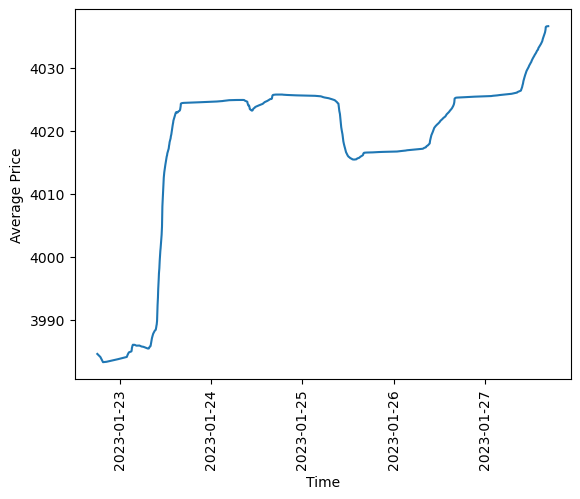

In [145]:
def draw_dollar_bar(dollar_bar, T):
    plt.xticks(rotation=90)
    plt.plot(T, dollar_bar)
    plt.ylabel("Average Price")
    plt.xlabel("Time");
draw_dollar_bar(dollar_bar_price, T)

In [146]:
dollar_bar = pd.Series(
    dollar_bar_price, index= T, name="Price")

In [147]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos = max(0, float(sPos + diff.loc[i]))
        sNeg = min(0, float(sNeg + diff.loc[i]))
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [148]:
tEvents = getTEvents(dollar_bar, 2.)
print("tEvents length: {}".format(len(tEvents)))

tEvents length: 34


### Add Vertical Barrier t1

In [149]:
close = dollar_bar
t1 = addVerticalBarrier(tEvents, close, numDays=1)
print("add vertical barrier: t1 length: {}".format(len(t1)))
# NaT means no vertical boundary

add vertical barrier: t1 length: 28


In [150]:
trgt = pd.Series(np.ones(len(tEvents))*0.5, name='trgt', index=tEvents)
events = getEvents(close=close, tEvents=tEvents, ptSl=[1,1], trgt=trgt, minRet=.05, numThreads=2, t1=t1)

len of target: 34
len of events: 34


In [151]:
labeled = getBins(events, close)

In [152]:
labeled

,ret,bin
2023-01-23 03:09:00,0.009855,1.0
2023-01-23 08:37:00,0.009383,1.0
2023-01-23 09:44:00,0.008647,1.0
2023-01-23 09:52:00,0.008107,1.0
2023-01-23 10:02:00,0.007364,1.0
2023-01-23 10:14:00,0.006590,1.0
2023-01-23 10:26:00,0.006051,1.0
2023-01-23 10:42:00,0.005465,1.0
2023-01-23 10:58:00,0.004969,1.0
2023-01-23 11:06:00,0.004311,1.0
